R implementation in Colab (consolidated from https://github.com/sfrancesco21/depersonalisation/):
https://colab.research.google.com/drive/1JbsCjmQUakVb14uLJNb4hjxU5Ev7JI_B?usp=sharing

### References:
- Saini, F., Ponzo, S., Silvestrin, F. et al. Depersonalization disorder as a systematic downregulation of interoceptive signals. Sci Rep 12, 22123 (2022). https://doi.org/10.1038/s41598-022-22277-y

- Friston KJ, Parr T, de Vries B. The graphical brain: Belief propagation and active inference. Netw Neurosci. 2017;1(4):381-414. doi: 10.1162/NETN_a_00018. Epub 2017 Dec 31. PMID: 29417960; PMCID: PMC5798592.

http://creativecommons.org/licenses/by/4.0/

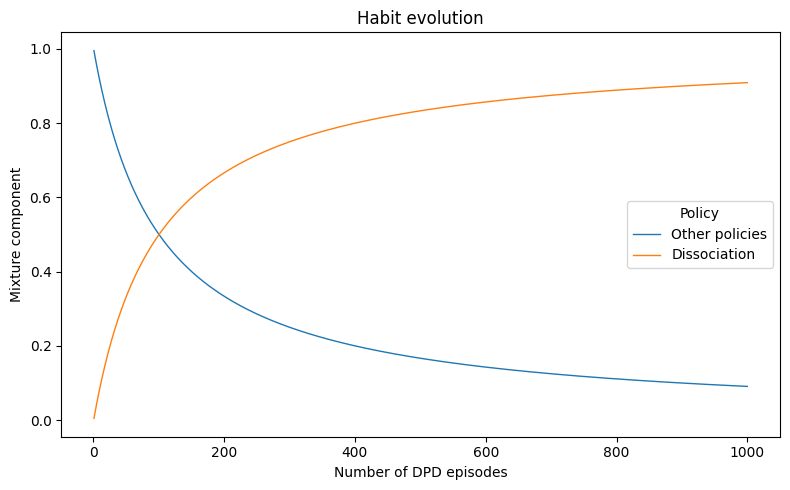

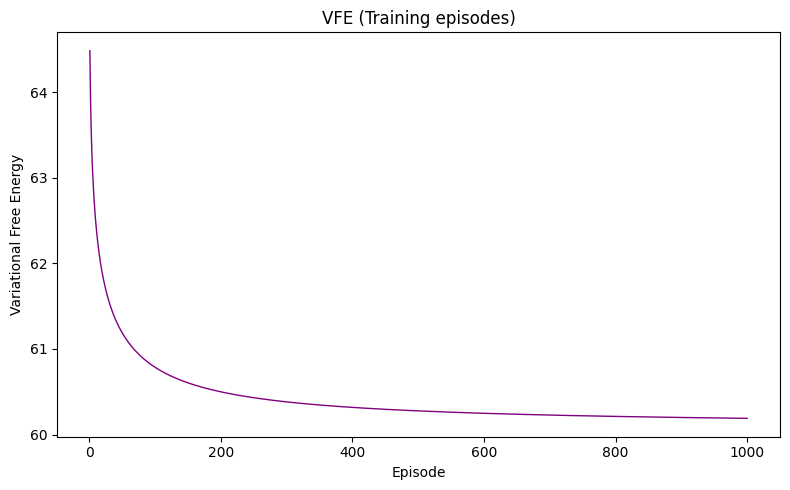

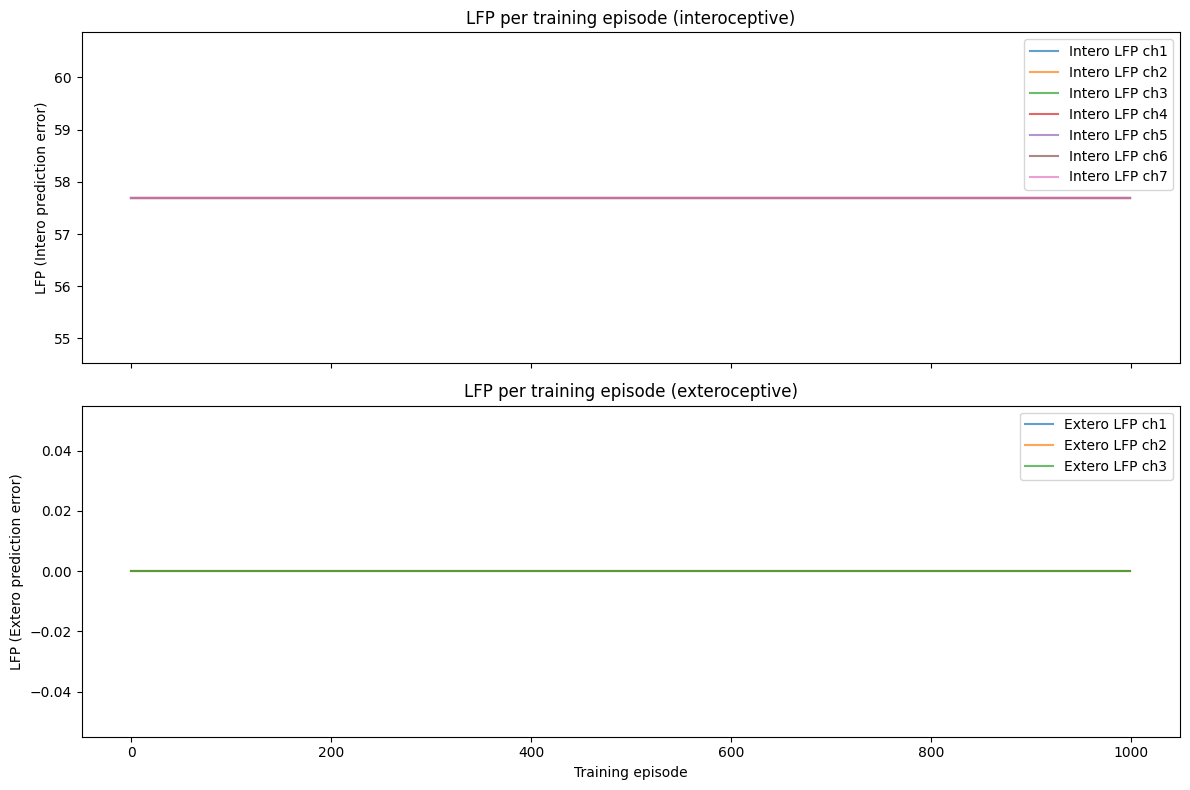

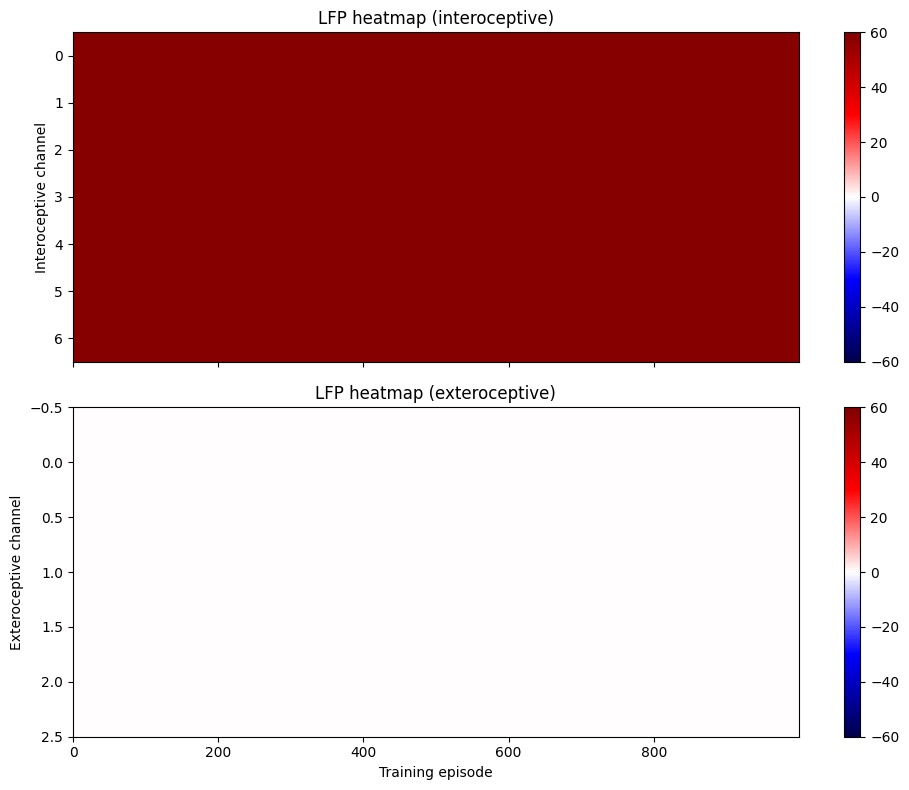

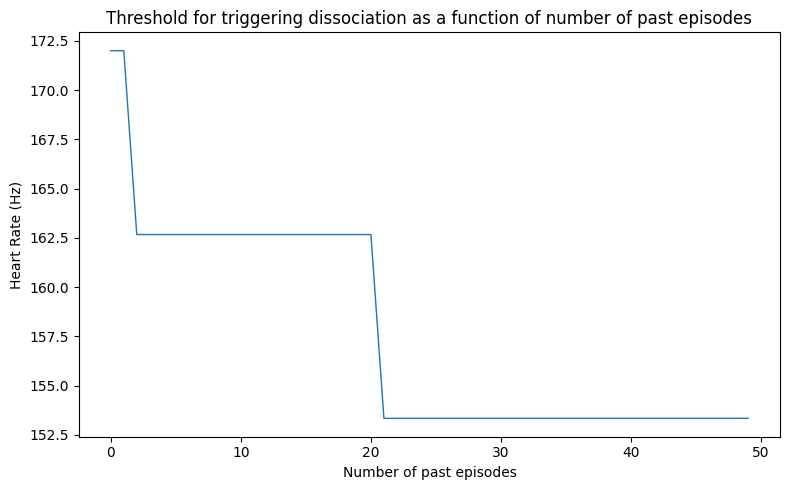

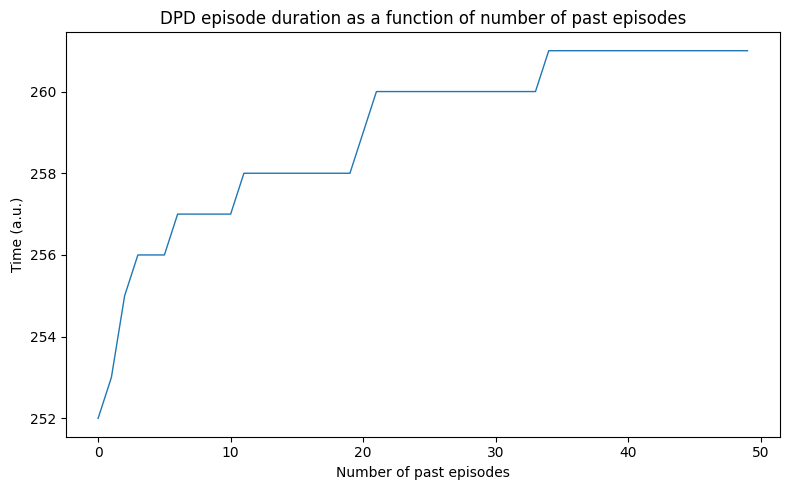

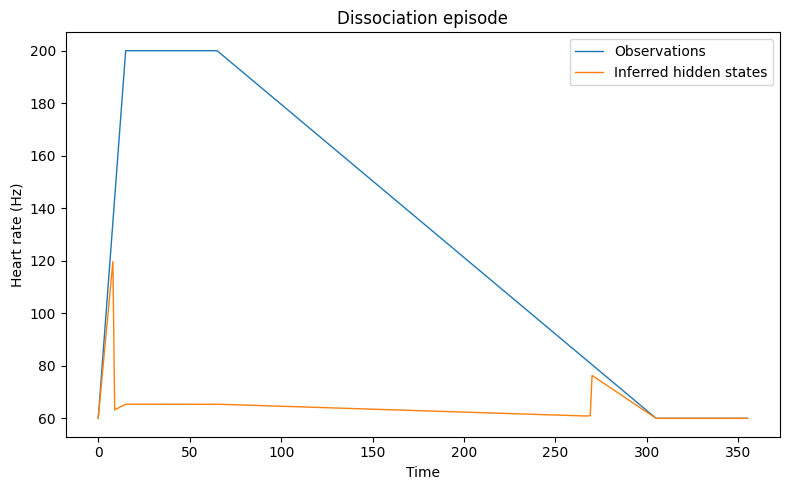

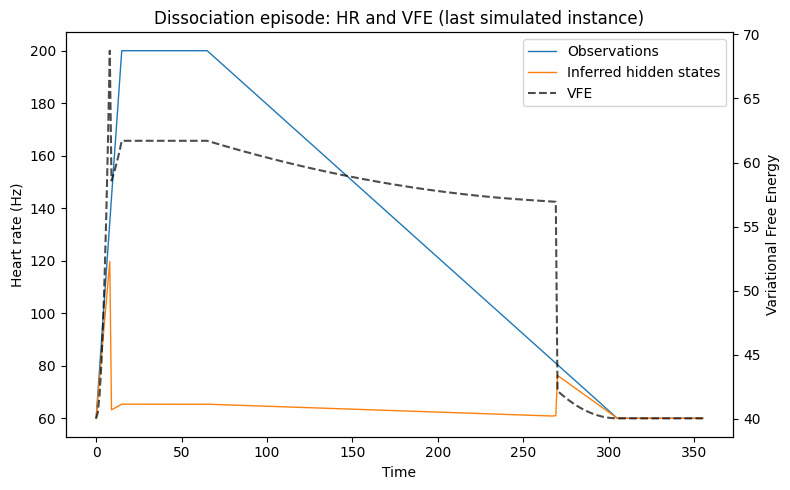

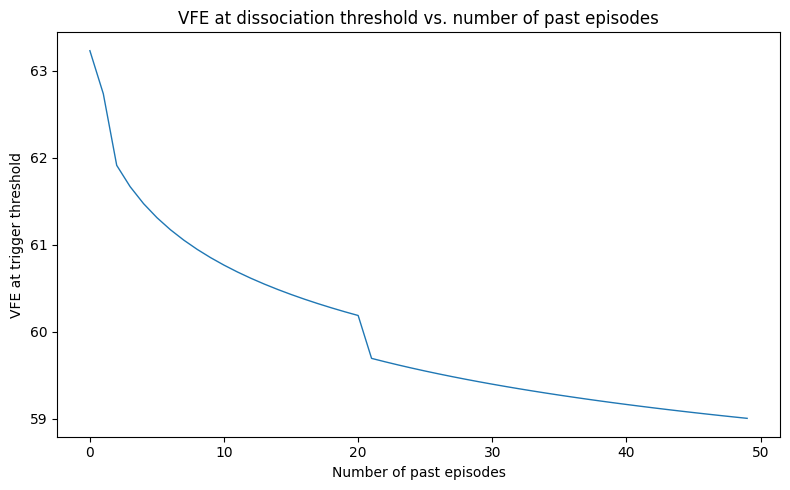

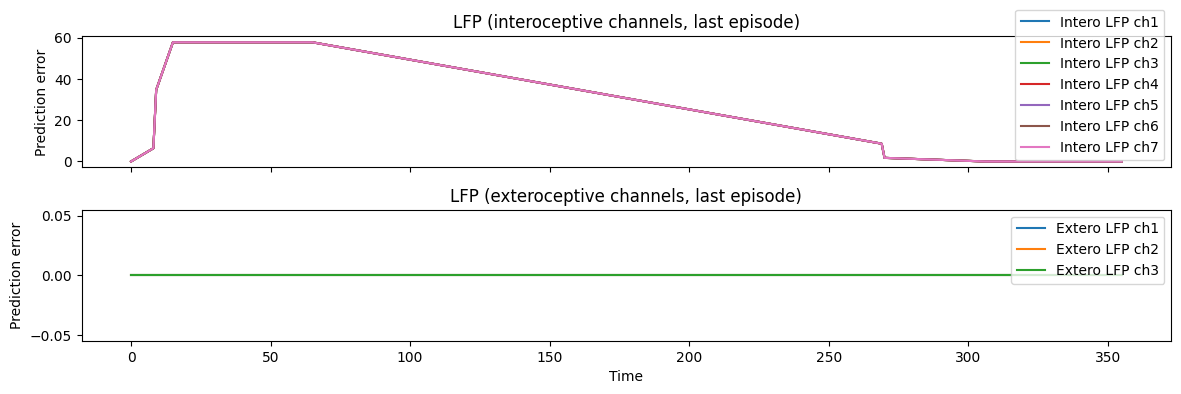

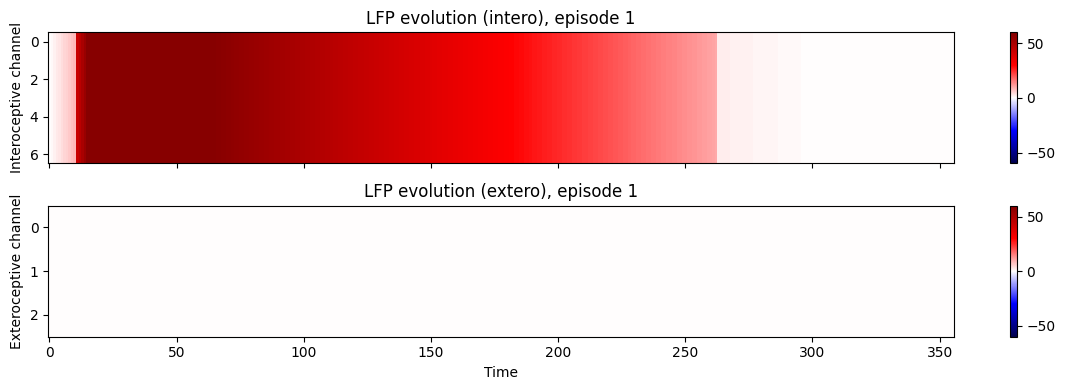

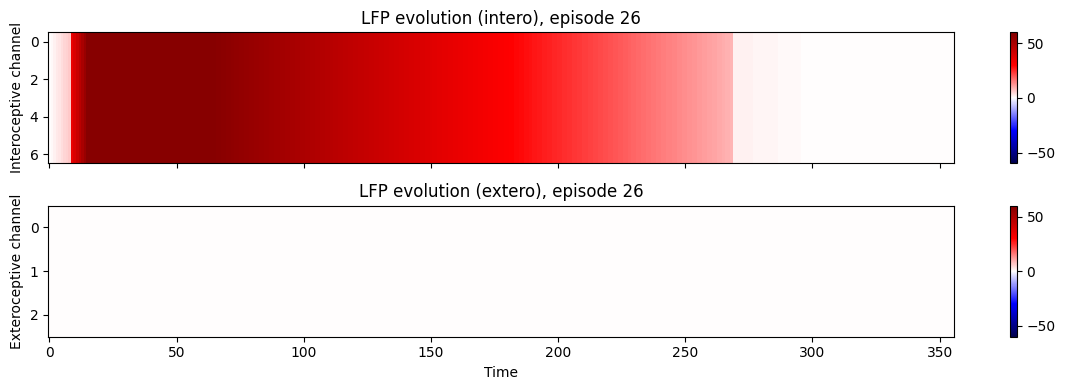

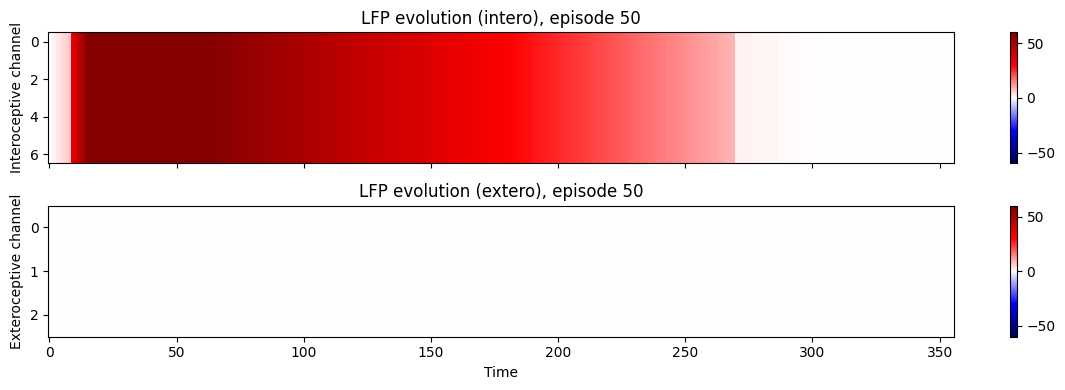

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import digamma
import matplotlib.pyplot as plt

# Channel indices
intero_idx = np.arange(7)
extero_idx = np.arange(7, 10)

# ------------------- STATISTICS & EM CORE -------------------
def compute_vfe(obs, s, z, c, mu, sigma_phi, sigma_s, theta, phi, alpha):
    K = len(phi)
    M = len(alpha)
    N = len(obs)
    log_p_s_given_z = 0.0
    for k in range(K):
        diff = s - mu[k, :]
        term = -0.5 * np.sum((diff ** 2) / sigma_phi + np.log(sigma_phi))
        log_p_s_given_z += z[k] * term
    log_p_o_given_s_c = 0.0
    for m in range(M):
        var_m = theta[m, :] * sigma_s
        diff = obs - s
        term = -0.5 * np.sum((diff ** 2) / var_m + np.log(var_m))
        log_p_o_given_s_c += c[m] * term
    log_p_z = np.sum(z * np.log(phi + 1e-12))
    E_ln_pi = digamma(alpha) - digamma(np.sum(alpha))
    log_p_c_given_pi = np.sum(c * E_ln_pi)
    log_joint = log_p_s_given_z + log_p_o_given_s_c + log_p_z + log_p_c_given_pi
    return -log_joint

def repmat(arr, n, m=None):
    arr = np.array(arr)
    if arr.ndim == 1: arr = arr.reshape(1, -1)
    if m is None: m = arr.shape[1]
    return np.tile(arr, (n, 1))

def Estep_z(s, phi, mu, sigma_phi, tau):
    rho = np.zeros(len(phi))
    for k in range(len(phi)):
        ln_rho = np.log(phi[k]) - np.sum(((s - mu[k, :]) ** 2 + (1 / tau)) / (2 * sigma_phi))
        rho[k] = np.exp(ln_rho)
    return rho / np.sum(rho)

def Estep_c(obs, alpha, s, sigma_s, theta, tau):
    rho = np.zeros(len(alpha))
    for m in range(len(alpha)):
        ln_rho = digamma(alpha[m]) - digamma(np.sum(alpha)) + \
                 np.sum(
                    -0.5 * np.log(sigma_s * theta[m, :]) -
                    (((obs - s) ** 2 + (1 / tau)) / (2 * theta[m, :] * sigma_s))
                 )
        rho[m] = np.exp(ln_rho)
    return rho / np.sum(rho)

def gradient_ascent(obs, s, theta, mu, sigma_s, sigma_phi, c, z):
    diff = 11
    csize, zsize = len(c), len(z)
    tau_s, tau_phi = 1 / sigma_s, 1 / sigma_phi
    old = np.zeros(2 * len(s))
    while np.max(np.abs(diff)) != 0.0:
        ds = c @ ((np.tile((obs - s), (csize, 1)) / (np.tile(sigma_s, (csize, 1)) * theta))) - \
             z @ ((np.tile(s, (zsize, 1)) - mu) / np.tile(sigma_phi, (zsize, 1)))
        d2s = -c @ (np.tile(tau_s, (csize, 1)) / theta) - z @ (np.tile(tau_phi, (zsize, 1)))
        s = s - ds / d2s
        tau = -d2s
        diff = old - np.concatenate((s, np.atleast_1d(tau).flatten()))
        diff = np.round(diff, 4)
        old = np.concatenate((s, np.atleast_1d(tau).flatten()))
    return s, tau

def Mstep(obs, s, z, c, mu, sigma_phi, sigma_s, theta, alpha_prior):
    alpha_post = alpha_prior + c
    pi = alpha_post / np.sum(alpha_post)
    s, tau = gradient_ascent(obs, s, theta, mu, sigma_s, sigma_phi, c, z)
    return pi, alpha_post, s, tau

# --------- TRAINING: Store/interoceptive and exteroceptive LFPs per episode ---------
def training(obs_train, mu, sigma_phi, sigma_s, theta, alpha_prior, phi, intero_idx, extero_idx):
    mixcom = np.zeros((obs_train.shape[0], len(alpha_prior)))
    vfe_train_trace = []
    lfp_train_intero = []  # store intero LFP for episode
    lfp_train_extero = []  # store extero LFP for episode
    curr_alpha = alpha_prior.copy()
    for t in range(obs_train.shape[0]):
        pi = curr_alpha / np.sum(curr_alpha)
        mixcom[t, :] = pi
        s = np.full(obs_train.shape[1], 20.0)
        tau = 1 / sigma_s
        old, diff = np.full(28, 12.0), 99
        alpha_post = curr_alpha.copy()
        while np.max(np.abs(diff)) != 0.0:
            z = Estep_z(s, phi.flatten(), mu, sigma_phi.flatten(), tau)
            c = Estep_c(obs_train[t, :], alpha_post.flatten(), s, sigma_s.flatten(), theta, tau)
            _, alpha_post, s, tau = Mstep(obs_train[t, :], s, z, c, mu, sigma_phi, sigma_s, theta, alpha_post)
            new = np.concatenate([s, z, c, np.atleast_1d(tau).flatten(), pi])
            diff = new - old
            diff = np.round(diff, 6)
            old = new
        vfe = compute_vfe(
            obs_train[t, :], s, z, c,
            mu, sigma_phi.flatten(), sigma_s.flatten(), theta, phi.flatten(), alpha_post.flatten()
        )
        vfe_train_trace.append(vfe)
        lfp_train_intero.append(obs_train[t, intero_idx] - s[intero_idx])
        lfp_train_extero.append(obs_train[t, extero_idx] - s[extero_idx])
        curr_alpha = alpha_post.copy()
    return mixcom, vfe_train_trace, lfp_train_intero, lfp_train_extero

# --------- EPISODE (TEST): LFPs for both channel types per episode ---------
def episode(obs_test, mu, sigma_phi, sigma_s, theta, alpha_prior, phi, intero_idx, extero_idx,
            store_lfp=True, precision_weighted=False):
    states_mu = np.zeros((obs_test.shape[0], obs_test.shape[1]))
    action = np.zeros((obs_test.shape[0], len(alpha_prior)))
    danger = np.zeros((obs_test.shape[0], mu.shape[0]))
    states_tau = np.zeros((obs_test.shape[0], obs_test.shape[1]))
    vfe_episode_trace = []
    lfp_list_intero, lfp_list_extero = [], []
    lfp_prec_weighted_list_intero, lfp_prec_weighted_list_extero = [], []
    pi = alpha_prior / np.sum(alpha_prior)
    s = obs_test[0, :].copy()
    tau = 1 / sigma_s
    for t in range(obs_test.shape[0]):
        old = np.full(28, 12.0)
        diff = 99
        alpha_post = alpha_prior.copy()
        while np.max(np.abs(diff)) != 0.0:
            z = Estep_z(s, phi.flatten(), mu, sigma_phi.flatten(), tau)
            c = Estep_c(obs_test[t, :], alpha_prior.flatten(), s, sigma_s.flatten(), theta, tau)
            pi, alpha_post, s, tau = Mstep(obs_test[t, :], s, z, c, mu, sigma_phi, sigma_s, theta, alpha_prior)
            new = np.concatenate([s, z, c, np.atleast_1d(tau).flatten(), pi])
            diff = new - old
            diff = np.round(diff, 6)
            old = new
        states_mu[t, :] = s
        action[t, :] = c
        danger[t, :] = z
        states_tau[t, :] = tau
        vfe_t = compute_vfe(
            obs_test[t, :], s, z, c,
            mu, sigma_phi.flatten(), sigma_s.flatten(), theta, phi.flatten(), alpha_post.flatten()
        )
        vfe_episode_trace.append(vfe_t)
        if store_lfp:
            lfp_intero = obs_test[t, intero_idx] - s[intero_idx]
            lfp_extero = obs_test[t, extero_idx] - s[extero_idx]
            lfp_list_intero.append(lfp_intero)
            lfp_list_extero.append(lfp_extero)
            if precision_weighted:
                lfp_weighted_intero = np.sqrt(tau[intero_idx]) * lfp_intero
                lfp_weighted_extero = np.sqrt(tau[extero_idx]) * lfp_extero
                lfp_prec_weighted_list_intero.append(lfp_weighted_intero)
                lfp_prec_weighted_list_extero.append(lfp_weighted_extero)
    lfp_array_intero = np.array(lfp_list_intero) if store_lfp else None
    lfp_array_extero = np.array(lfp_list_extero) if store_lfp else None
    lfp_prec_weighted_array_intero = np.array(lfp_prec_weighted_list_intero) if (store_lfp and precision_weighted) else None
    lfp_prec_weighted_array_extero = np.array(lfp_prec_weighted_list_extero) if (store_lfp and precision_weighted) else None
    return states_mu, action, danger, states_tau, vfe_episode_trace, lfp_array_intero, lfp_array_extero, \
        lfp_prec_weighted_array_intero, lfp_prec_weighted_array_extero

# ============== MAIN SCRIPT ==============
phi = np.array([0.99, 0.01])
alpha_prior = np.array([100, 100, 1])
sigma_s = np.full((10,), 25.0)
sigma_phi = np.full((10,), 100.0)
theta = np.ones((3, 10))
theta[2, :7] = 100.0
mu = np.vstack((np.full(10, 20.0), np.full(10, 80.0)))
panic_stim = np.concatenate((np.full((1,7), 80.0), np.full((1,3), 20.0)), axis=1)
obs_train = repmat(panic_stim, 1000)

# TRAINING PHASE
mixcom, vfe_train_trace, lfp_train_intero, lfp_train_extero = training(
    obs_train, mu, sigma_phi, sigma_s, theta, alpha_prior, phi, intero_idx, extero_idx)
mixcom_df = pd.DataFrame({
    'Other policies': mixcom[:, 0] + mixcom[:, 1],
    'Dissociation': mixcom[:, 2]
})

# Habit Evolution Plot
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(mixcom_df)+1), mixcom_df['Other policies'], label='Other policies', linewidth=1)
plt.plot(np.arange(1, len(mixcom_df)+1), mixcom_df['Dissociation'], label='Dissociation', linewidth=1)
plt.title("Habit evolution")
plt.xlabel("Number of DPD episodes")
plt.ylabel("Mixture component")
plt.legend(title="Policy")
plt.tight_layout()
plt.show()

# VFE Per Training Episode
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(vfe_train_trace)+1), vfe_train_trace, color='purple', linewidth=1)
plt.title("VFE (Training episodes)")
plt.xlabel("Episode")
plt.ylabel("Variational Free Energy")
plt.tight_layout()
plt.show()

# 2x1 Intero/Extero LFP per episode
lfp_intero_arr = np.vstack(lfp_train_intero)
lfp_extero_arr = np.vstack(lfp_train_extero)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for ch in range(lfp_intero_arr.shape[1]):
    axes[0].plot(lfp_intero_arr[:, ch], label=f'Intero LFP ch{ch+1}', alpha=0.7)
axes[0].set_ylabel("LFP (Intero prediction error)")
axes[0].set_title("LFP per training episode (interoceptive)")
axes[0].legend()
for ch in range(lfp_extero_arr.shape[1]):
    axes[1].plot(lfp_extero_arr[:, ch], label=f'Extero LFP ch{ch+1}', alpha=0.7)
axes[1].set_ylabel("LFP (Extero prediction error)")
axes[1].set_title("LFP per training episode (exteroceptive)")
axes[1].set_xlabel("Training episode")
axes[1].legend()
plt.tight_layout()
plt.show()

# 2x1 LFP heatmap
fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)
im0 = axes[0].imshow(lfp_intero_arr.T, aspect='auto', interpolation='none', cmap='seismic', vmin=-60, vmax=60)
axes[0].set_ylabel("Interoceptive channel")
axes[0].set_title("LFP heatmap (interoceptive)")
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(lfp_extero_arr.T, aspect='auto', interpolation='none', cmap='seismic', vmin=-60, vmax=60)
axes[1].set_ylabel("Exteroceptive channel")
axes[1].set_title("LFP heatmap (exteroceptive)")
axes[1].set_xlabel("Training episode")
fig.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.show()

# Test Phase setup
int_test = np.concatenate([4 * np.arange(5, 21), np.full(50, 80.0), 80 - 0.25 * np.arange(1, 241), np.full(50, 20.0)])
N = len(int_test)
int_mat = np.tile(int_test, (7, 1)).T
ext_test = np.full((N, 3), 20.0)
obs_test = np.c_[int_mat, ext_test]

max_ep = 50
duration = np.zeros(max_ep)
threshold = np.zeros(max_ep)
ep = np.arange(max_ep)
vfe_episode_full = []
vfe_threshold_idx = []
lfp_all_episodes_intero = []
lfp_all_episodes_extero = []
threshold_idxs = []

for j in range(max_ep):
    n_past_episodes = j
    curr_alpha_prior = np.array([100, 100, n_past_episodes + 1])
    res = episode(
        obs_test, mu, sigma_phi, sigma_s, theta, curr_alpha_prior, phi,
        intero_idx, extero_idx, store_lfp=True, precision_weighted=True
    )
    prob_dissociation = res[1][:, 2]
    duration[j] = np.sum(prob_dissociation > 0.5)
    threshold_idx = np.sum(prob_dissociation[:150] < 0.5) + 1
    threshold[j] = obs_test[threshold_idx, 0] if threshold_idx < obs_test.shape[0] else np.nan
    threshold_idxs.append(threshold_idx)
    lfp_all_episodes_intero.append(res[5])  # (T, 7)
    lfp_all_episodes_extero.append(res[6])  # (T, 3)
    if j == max_ep-1:
        plot_data = pd.DataFrame(np.c_[
            obs_test[:, 0],
            res[0][:, 0],
            res[1][:, 2],
            res[3][:, 0],
            res[4]  # VFE
        ], columns=['obs', 'state_mu', 'policy_3', 'tau', 'VFE'])
        vfe_episode_full = res[4]
    if threshold_idx < obs_test.shape[0]:
        vfe_threshold_idx.append(res[4][threshold_idx])
    else:
        vfe_threshold_idx.append(np.nan)

m = 140/60
q = 60 - (140/3)
plot_data['HR_obs'] = plot_data['obs'] * m + q
plot_data['HR_hs'] = plot_data['state_mu'] * m + q
threshold_HR = threshold * m + q
plot2 = pd.DataFrame({'threshold_HR': threshold_HR, 'duration': duration})

# Original plots retained exactly as before
plt.figure(figsize=(8,5))
plt.plot(ep, plot2['threshold_HR'], linewidth=1)
plt.title("Threshold for triggering dissociation as a function of number of past episodes")
plt.xlabel("Number of past episodes")
plt.ylabel("Heart Rate (Hz)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(ep, plot2['duration'], linewidth=1)
plt.title("DPD episode duration as a function of number of past episodes")
plt.xlabel("Number of past episodes")
plt.ylabel("Time (a.u.)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(plot_data.shape[0]), plot_data['HR_obs'], label='Observations', linewidth=1)
plt.plot(range(plot_data.shape[0]), plot_data['HR_hs'], label='Inferred hidden states', linewidth=1)
plt.title("Dissociation episode")
plt.xlabel("Time")
plt.ylabel("Heart rate (Hz)")
plt.legend()
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(8,5))
x = range(plot_data.shape[0])
ln1 = ax1.plot(x, plot_data['HR_obs'], color='tab:blue', label='Observations', linewidth=1)
ln2 = ax1.plot(x, plot_data['HR_hs'], color='tab:orange', label='Inferred hidden states', linewidth=1)
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart rate (Hz)")
ax1.tick_params(axis='y', labelcolor='black')
ax2 = ax1.twinx()
ln3 = ax2.plot(x, plot_data['VFE'], color='black', linestyle='--', label='VFE', linewidth=1.5, alpha=0.7)
ax2.set_ylabel("Variational Free Energy", color='black')
ax2.tick_params(axis='y', labelcolor='black')
lns = ln1 + ln2 + ln3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper right', frameon=True)
plt.title("Dissociation episode: HR and VFE (last simulated instance)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(ep, vfe_threshold_idx, linewidth=1)
plt.title("VFE at dissociation threshold vs. number of past episodes")
plt.xlabel("Number of past episodes")
plt.ylabel("VFE at trigger threshold")
plt.tight_layout()
plt.show()

# ---- 2x1 LFP PLOT for last test episode ----
fig, axes = plt.subplots(2, 1, figsize=(12,4), sharex=True)
lfp_last_intero = lfp_all_episodes_intero[-1]
if lfp_last_intero is not None:
    for i in range(lfp_last_intero.shape[1]):
        axes[0].plot(lfp_last_intero[:, i], label=f'Intero LFP ch{i+1}')
    axes[0].set_title("LFP (interoceptive channels, last episode)")
    axes[0].legend()
lfp_last_extero = lfp_all_episodes_extero[-1]
if lfp_last_extero is not None:
    for i in range(lfp_last_extero.shape[1]):
        axes[1].plot(lfp_last_extero[:, i], label=f'Extero LFP ch{i+1}')
    axes[1].set_title("LFP (exteroceptive channels, last episode)")
    axes[1].legend()
axes[1].set_xlabel("Time")
axes[0].set_ylabel("Prediction error")
axes[1].set_ylabel("Prediction error")
plt.tight_layout()
plt.show()

# ---- 2x1 LFP heatmaps for episodes 1, mid, last ----
for j in [0, max_ep//2, max_ep-1]:
    lfp_i, lfp_e = lfp_all_episodes_intero[j].T, lfp_all_episodes_extero[j].T
    fig, axes = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    im0 = axes[0].imshow(lfp_i, aspect='auto', interpolation='none', cmap='seismic', vmin=-60, vmax=60)
    axes[0].set_ylabel("Interoceptive channel")
    axes[0].set_title(f"LFP evolution (intero), episode {j+1}")
    fig.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(lfp_e, aspect='auto', interpolation='none', cmap='seismic', vmin=-60, vmax=60)
    axes[1].set_ylabel("Exteroceptive channel")
    axes[1].set_title(f"LFP evolution (extero), episode {j+1}")
    axes[1].set_xlabel("Time")
    fig.colorbar(im1, ax=axes[1])
    plt.tight_layout()
    plt.show()


| DPD Paper Notation          | Python Code Alias            | The Graphical Brain Notation      | Explanation                                                                                          |
|-----------------------------|------------------------------|-----------------------------------|------------------------------------------------------------------------------------------------------|
| $o$                         | `obs`, `obs_train`, `obs_test` | $o$                              | Sensory observations (inputs), from interoceptive and exteroceptive channels.                        |
| $s$                         | `s`, `states_mu`             | $s$ (continuous)                  | Latent continuous hidden states; agent’s internal estimate of bodily state (e.g., heart rate).        |
| $z$                         | `z`, `danger`                | $s$ (higher-level, discrete)      | Latent discrete higher-level state ("safe" vs "danger" context state).                                |
| $c$, $\hat{c}_m$            | `c`, `action`                | $\pi$, $\mathbb{E}[\pi]$          | Policy probability/posterior (probability agent enacts each policy: e.g., dissociation).              |
| $\pi$ (policy habit)        | `pi`                         | $\pi$                            | Prior probability over policy selection (habit/prior for each action/policy).                         |
| $\alpha$                    | `alpha`, `alpha_prior`, `alpha_post` | $\alpha$                  | Dirichlet concentration parameters for policy habits (learned computation of habitual response).      |
| $\phi$                      | `phi`                        | $C$ (preference vector)           | Preference over higher-level states (goal state probabilities—e.g., favor "safe" over "danger").      |
| $\mu$                       | `mu`                         | $\mu$, $D$                       | Prior mean for each state/channel (expected values under each high-level state).                      |
| $\sigma^2_s$ (or $\Sigma_s$)| `sigma_s`                    | $\Sigma$, $\sigma^2$ (state noise)| Channel-specific variance; noise/precision of state prediction for each sensory channel.              |
| $\sigma^2_\phi$ (or $\Sigma_\phi$)| `sigma_phi`           | $\Sigma$, $\sigma^2$ (context noise)| Variance for higher-level state inference.                                                       |
| $\theta_{m,n}$              | `theta`                      | - (policy effect param.)           | Policy- and channel-specific noise/precision modifier (elevated for dissociation/interoception).      |
| $\rho$                      | `rho`                        | - (softmax aux variable)           | Intermediate for unnormalized softmax weights in E-step expectation steps.                           |
| $\mathrm{digamma}(\alpha)$  | `digamma`                    | $\psi(\cdot)$                    | Digamma (special function for Dirichlet parameter expectation step in policy inference).              |
| $q^*(\cdot)$                | -                            | $Q(\cdot)$                       | Variational approximate posterior over states, policies, and parameters (mean-field VB).              |
| $F$ or VFE                  | -                            | $F$                              | Variational Free Energy, minimized during inference (objective function).                             |
| $\hat{s}_n$                 | `s`, `state_mu`              | $\mathbb{E}[s_n]$                | Posterior mean for state $n$; agent’s best guess of true bodily state in channel $n$.                 |
| $\hat{z}_k$                 | `z`                          | $\mathbb{E}[z_k]$                | Posterior probability for higher-level state $k$ at each iteration.                                   |
| $\hat{c}_m$                 | `c`, `action`                | $\mathbb{E}[\pi_m]$              | Posterior probability for policy $m$ (e.g., dissociation policy).                                     |
| $\tau$, $\tau_n$            | `tau`, `states_tau`           | $\tau$ (precision)               | Precision (inverse variance) of state estimate for each channel (from Laplace/gradient ascent).        |
| $\Delta \alpha$             | -                            | $\alpha' - \alpha$                | Update to Dirichlet habit parameters (policy habit update after each episode/trial).                  |
| $K$                         | - (2 in this code)           | $K$                              | Number of high-level hidden states (here: 2; "safe", "danger").                                      |
| $M$                         | - (3 in this code)           | $M$                              | Number of candidate policies/actions (in code: 3).                                                   |
| $N$                         | - (10 in this code)          | $N$                              | Number of sensory channels (e.g. 10: 7 interoceptive, 3 exteroceptive).                              |
| $\mathrm{repmat}$           | `repmat`                     | -                                | MATLAB-like utility to repeat arrays for synthetic data construction.                                  |
| Estep_z()                   | `Estep_z`                    | E-step update for $z$             | Computes posterior over higher-level state (context), given current state and preferences.            |
| Estep_c()                   | `Estep_c`                    | E-step update for $c$             | Computes posterior over policy (habit) selections.                                                   |
| gradient_ascent()           | `gradient_ascent`            | Laplace-Newton update for $s$     | Gradient (Newton) ascent to find optimal continuous hidden state fit to evidence.                     |
| Mstep()                     | `Mstep`                      | M-step (EM update for $\alpha$, $s$, $\pi$)| Maximization step: updates policy priors, state, and Dirichlet parameters (habit learning).           |
| training()                  | `training`                   | Multiple-episode habit learning   | Simulates DPD habit formation across repeated episodes (over trials).                                 |
| episode()                   | `episode`                    | Single episode simulation         | Simulates all state and policy inferences over time during a single DPD episode.                      |


# Plots explanation

## Here’s a concise breakdown of what each plot in the code represents, mapped directly to the modeling results in the paper:

### 1. Habit Evolution Plot

- **What it shows:**  
  The evolution of *habit probabilities* (priors) for two types of policies over repeated exposure to depersonalization disorder (DPD) episodes:
    - "Other policies": non-dissociative (ordinary) responses.
    - "Dissociation": the specific dissociative/interoceptive silencing policy.

- **Interpretation:**  
  As the number of repeated DPD episodes increases, the likelihood ("habit strength") of the agent picking the dissociation policy increases, while the probability of ordinary policies decreases. In other words, the agent learns to dissociate by habit.

- **Paper figure:**  
  Matches Figure 2 in the article.

### 2. Threshold for Triggering Dissociation Plot

- **What it shows:**  
  The simulated *heart rate* threshold (physiological arousal) needed to trigger a dissociative episode as a function of the number of past DPD episodes.

- **Interpretation:**  
  The more prior dissociative episodes the agent has had, the lower the arousal required to trigger another dissociative response. This models how, over time, chronic DPD can be triggered by less intense situations.

- **Paper figure:**  
  Figure 3c.

### 3. DPD Episode Duration Plot

- **What it shows:**  
  The *duration* (number of time steps) a dissociative episode lasts, as a function of the number of past episodes.

- **Interpretation:**  
  With more prior DPD experiences, the dissociative ("silenced") episode lasts longer. This mimics how chronic depersonalization becomes more persistent with repetition.

- **Paper figure:**  
  Figure 3b.

### 4. Dissociation Episode (Heart Rate) Plot

- **What it shows:**  
  For the last (“most conditioned”) simulated DPD episode, the plot tracks:
    - The actual observed heart rate input (HR_obs),
    - The agent's inferred/estimated internal state (HR_hs).

- **Interpretation:**  
  When the dissociation policy activates, the inferred internal state (the model's conscious awareness of heart rate) is abruptly "silenced," diverging from the actual observed data—mimicking the blunted, detached experience of the body seen in depersonalization.

- **Paper figure:**  
  Figure 3a.

Each plot visually conveys a core mechanism of the paper’s computational model: how repeated unresolved conflicts between interoception and exteroception drive a learned, automatic tendency toward depersonalization, lowering the threshold for episodes and making dissociation more persistent over time.

# Hierarchical Message Passing (with differences from canonical form found in Active Inference)

## Comparison to "Mixed Models" in "The graphical brain" (Friston et. al, 2017)

- The "Mixed Models" section in *The Graphical Brain* paper[1][2] details how discrete (categorical) and continuous (real-valued) variables can interact within a unified generative model. This is fundamental in Active Inference, where discrete high-level states (like “context” or “policy”) modulate, and are in turn informed by, lower-level continuous state-space inferences (such as bodily states or sensory estimates). This bidirectional coupling is mediated by explicit "link functions"—mathematical factors in the generative model or inference schedule that specify (a) how discrete outcomes/categorical priors pass as empirical priors for continuous models, and (b) how the evidence accumulated by the continuous level is re-cast as evidence for a given discrete prior via Bayesian model comparison or averaging.

### 1. The Link Function in *The Graphical Brain*

- The discrete model sets empirical priors on the continuous model (e.g., which “regime” or “policy” is active dictates which continuous trajectory is likely).
- The continuous model, after integrating evidence, provides log model evidence or posterior probability for each possible discrete cause—in effect, “returning” an observation (e.g., how well does each discrete policy explain the data?).
- This is formalized as a *link* node/factor in the Forney factor graph, embodying Bayesian model selection/averaging: the descending message is an average of the continuous (dynamic) models defined by each discrete state; ascending message is the model evidence for each discrete state, given the continuous trajectory.
- This structure is essential for hierarchical deep generative models, allowing, for instance, high-level categorical goals (plans, contexts, or intentions) to dynamically select the low-level dynamics, and to update as those lower-level systems accumulate continuous evidence.

### 2. Does the DPD Paper and Code Use a Link Function?

**Careful analysis of the DPD paper, its mathematical description, and the simulation code reveals:**

- The DPD model *does* implement hierarchical inference, with a discrete high-level “context” variable ($z$; safe vs. danger), and a discrete “policy” variable ($c$; dissociation vs. other responses), along with continuous hidden states ($s$; internal physiological estimates).
- **However, the linkage between the discrete and continuous levels in the DPD model is implemented in a more “shallow” or simplified manner** than the explicit mixed model link function described in The Graphical Brain.

#### How is the linkage realized in the DPD model?

- **Descending Influence:** Discrete states ($z$, $c$) set the means ($\mu$) and variances ($\sigma^2$, $\theta$) for the continuous state inference ($s$). For example:
    - The dissociation policy increases the variance ($\theta$) of the interoceptive channels, modulating how much observed bodily states $o$ impact the inferred $s$. This is a direct way the policy $c$ (discrete) modulates the mapping for $s$ (continuous).
    - Context $z$ determines which $\mu$ (e.g., safe or danger mean) is used as the prior for $s$.
- **Ascending Influence:** The likelihoods/costs for discrete variable inference (over $z$ or $c$) are directly functions of the free energy or “fit” of the continuous inference $s$ to the observations.
    - Specifically, the softmax for $c$ (policy) and $z$ (state) uses terms containing the prediction error from $s$ (from the E-step formulas).
- **There is no explicit “link node” or post-hoc Bayesian model comparison as a separate factor or inference step**: the connection is encoded directly in the variational free energy, via the forms of the likelihoods and precisions, rather than as explicit marginalization or model averaging operations.
    - There is no code step where the continuous $s$ “returns” marginal likelihoods for discrete alternatives, as in the explicit mixed model setting.
    - Instead, all coupling is “baked” into the equations for the posteriors (in the $Estep_z$, $Estep_c$, and the gradient_ascent routines).

#### In summary:

- **The DPD model and code do manifest bi-directional flow between discrete and continuous variables, but in a special/streamlined way:**
    - *Descending*: Discrete choices set priors/precisions for continuous inference.
    - *Ascending*: Quality of the continuous fit (prediction error under each “regime”) directly determines discrete probabilities.
- **This is mathematically related to the link functions of The Graphical Brain, but is implemented as “integrated” likelihoods/free energies, not explicit model averaging or explicit link nodes.**
- **There is no Bayesian model selection over continuous models per discrete cause:** Rather, all possibilities are compared “on the fly” in the E-step softmax. The process is streamlined for efficiency, suited for the specific application rather than general hybrid, deep, or branching hierarchies with more complex linking needs.

### 3. Why Might the DPD Paper Use This Implementation?

- The primary aim was explanatory parsimony: the model is designed to instantiate the minimal plausible hierarchical inference architecture needed to explain DPD phenomena—habit learning of dissociative response, context-driven switching, and interoceptive silencing.
- The computational structure is sufficient for simulating the “on-off” nature of DPD episodes and their habit formation dynamics, without requiring explicit hybrid link nodes.
- The approach reduces redundancy for the two-level problem (context/policy and hidden state), consistent with standard active inference schemes for shallow hierarchies.

**In conclusion:**  
The DPD paper and code realize the core principles of mixed/hierarchical models from The Graphical Brain—discrete-continuous bidirectional coupling—by integrating the link function logic within their variational updates. However, they do so in a minimal way: not as a general or explicit link-node factor, but by using discrete variables to parametrize priors/precisions for continuous inference, and using the resulting prediction errors to update discrete beliefs via softmax normalization. This is mathematically a form of hybrid inference, but does not fully instantiate the modular, factorized link structure outlined for general mixed models in The Graphical Brain[1][2][3].

[1] https://pmc.ncbi.nlm.nih.gov/articles/PMC5798592/
[2] https://direct.mit.edu/netn/article-abstract/1/4/381/5401
[3] https://www.nature.com/articles/s41598-022-22277-y
[4] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/attachments/13022412/97790adf-7a3d-45dd-be8f-66b966762612/s41598-022-22277-y.pdf
[5] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/attachments/13022412/7b611ff6-374b-4e44-bba7-c6c7b4d4692f/netn-01-381-1.pdf
[6] https://pubmed.ncbi.nlm.nih.gov/29417960/
[7] https://www.sciencedirect.com/science/article/abs/pii/S1053811915002037
[8] https://arxiv.org/abs/2506.02044
[9] https://arxiv.org/pdf/0711.1609.pdf
[10] https://www.nature.com/articles/s41467-022-28323-7
[11] https://pmc.ncbi.nlm.nih.gov/articles/PMC7673417/
[12] https://wires.onlinelibrary.wiley.com/doi/full/10.1002/wcms.70018
[13] https://www.sciencedirect.com/science/article/pii/S089662732100845X
[14] https://www.sciencedirect.com/science/article/pii/S1053810022000526
[15] https://www.stat.washington.edu/adobra/Files/Papers/massam-liu-dobra.pdf
[16] https://link.springer.com/article/10.1007/s42113-021-00113-2
[17] https://www.nature.com/articles/s41598-024-56119-w
[18] https://pubs.aip.org/aip/jcp/article/146/15/150901/152357/Perspective-Dissipative-particle-dynamics
[19] https://pmc.ncbi.nlm.nih.gov/articles/PMC8934883/
[20] https://www.casact.org/sites/default/files/2021-02/compartmental-reserving-models-gesmannmorris0820.pdf
[21] https://www.sciencedirect.com/science/article/pii/S0149763425002970
[22] https://pmc.ncbi.nlm.nih.gov/articles/PMC2988450/

# Step-by-step explanation

## Here is a step-by-step, comprehensive explanation of what the attached Python code does, relating each part to the depersonalization disorder model presented in the referenced paper[1]. The answer will walk through the code in logical segments:

## Initialization and Utility Functions

### repmat(arr, n, m=None)
- **Purpose:** Replicates an array in MATLAB’s style, commonly used to construct matrices where the same row (observation or stimulus) is repeated multiple times.
- **Role in simulation:** Used for constructing repeated input data (e.g., simulating repeated identical panic observations).

## Core Inference (“E-step”) Functions

### Estep_z(s, phi, mu, sigma_phi, tau)
- **Purpose:** Computes the posterior probability $z$ over higher-level (integrated) “danger” states given the current estimated states $ s $, prior probabilities $ \phi $, state means $ \mu $, state variances $ \sigma_\phi $, and precision $ \tau $.
- **How:** For each state $ k $, computes log-probabilities based on top-down (prior) and bottom-up (likelihood) components, normalizes (softmax) to get probabilities.
- **Role:** Determines how likely the observed body state matches “safety” vs “danger”.

### Estep_c(obs, alpha, s, sigma_s, theta, tau)
- **Purpose:** Computes the posterior probability (policy selection) $ c $ over possible actions/policies (e.g., normal/other vs “dissociation”), given inputs and internal state.
- **How:** For each policy $ m $, computes log-probabilities based on learned habit priors (`alpha`), current/fitted state (`s`), observations, and variance-modulation (`theta`) over channels.
- **Role:** Determines the agent’s tendency to deploy policies, e.g., favoring dissociation as repeated episodes accumulate.

## M-step and Gradient Ascent

### gradient_ascent(obs, s, theta, mu, sigma_s, sigma_phi, c, z)
- **Purpose:** Optimizes the hidden state $ s $ and associated precisions by gradient ascent (actually Newton-style optimization) to maximize variational free energy.
- **How:** Iteratively updates $ s $ using the expected gradients, combining the influence of current observations, prior means, “policy” weighting, etc.
- **Role:** Refines guess of true internal states (e.g., bodily feelings, interoceptive signals) given both exteroceptive and interoceptive observations, under current policy beliefs.

### Mstep(obs, s, z, c, mu, sigma_phi, sigma_s, theta, alpha_prior)
- **Purpose:** Updates the Dirichlet prior over policy selection, and calls the optimization routine for inferred states.
- **How:** Posterior over policy-prior (`alpha_post`) is updated by adding in current action/probability for each component. Posterior distribution over `pi` (policy mixture) is normalized; new state estimates returned.
- **Role:** Consolidates new experience/habit learning into priors, refines internal state.

## High-level Simulation Loops

### training(obs_train, mu, sigma_phi, sigma_s, theta, alpha_prior, phi)
- **Purpose:** Simulates the **habit formation** process across many repeated DPD-like episodes.
- **How:**
    - Runs for each “episode” (row in `obs_train`, usually representing identical panic-like inputs).
    - For each episode, starts with initial state, iteratively runs the E/M steps (as above) to optimize posteriors until convergence.
    - Habit priors (`alpha`) are progressively updated and carried forward, tracking the growing tendency to dissociate after repeated exposure.
- **Output:** Returns, for every episode, the current prior probability of choosing dissociation vs. other policies.
- **Role:** Models the development of a “dissociative habit” as described in the paper—how repeated exposure to conflictual signals increases the likelihood of future dissociation.

### episode(obs_test, mu, sigma_phi, sigma_s, theta, alpha_prior, phi)
- **Purpose:** Simulates a **single DPD episode** in temporal detail.
- **How:**
    - Given a time-series of observations, for each time step, optimizes the internal state and policy probabilities using the E/M steps until convergence.
    - Tracks inferred hidden state, the probability of dissociate action, “danger” state probability, and precisions over time.
- **Output:** Returns timecourses for all these variables, used for plotting.
- **Role:** Used to visualize (a) how dissociation is triggered at high arousal, and (b) how this threshold and duration depends on past experience.

## Scripted Simulation and Plotting

### Main Model Parameters
- **phi:** Prior probabilities of high-level states (safe vs danger).
- **alpha_prior:** Prior over policies, with dissociation much less favored initially.
- **sigma_s, sigma_phi:** Variances for sensory channels and higher-level states.
- **theta:** Controls variance inflation in interoceptive channels during dissociation (makes bottom-up evidence less influential, matches paper’s “silencing”).

### *Habit Formation Simulation*
- **Input:** 1000 repeated “panic” observations (high interoceptive, low exteroceptive signals).
- **Simulation:** `mixcom = training(obs_train, ...)`
    - Tracks how the agent’s prior probability (habit) for dissociation grows after each repeated episode.
- **Plot:** How “mixture component” (policy prior) for dissociation increases towards 1 as episodes accumulate.

### *DPD Episode Simulations*
- **Input:** Realistic rising, plateau, and falling interoceptive signals with constant exteroceptive input.
- **Simulation Loop:** For 0 to 49 past episodes, set the dissociation prior to be higher (to simulate a participant with more chronic DPD), run the episode, and record:
    - **duration:** For how long within the episode is dissociation activated (prob > 0.5)?
    - **threshold:** What level of physiological arousal (heart rate) triggers dissociation?
- **Results:** Plotted as:
    - The threshold for triggering dissociation decreases as the agent becomes more “habitual”; i.e., with more past episodes, less arousal is needed for dissociation.
    - The duration of dissociation episodes increases with habit strength—supporting the chronicity model.

### *Visualization of a Single Episode (last one simulated)*
- **Plots:** Shows timecourse of observed heart rate, inferred internal state, and dissociation likelihood.
- **Interpretation:** Visually demonstrates “interoceptive silencing” (inferred state flattens out during dissociation), as in the paper’s Figure 3.

## Summary Table: Mapping Code to Theoretical Model

| Code Segment          | Theoretical Model Role                                              |
|----------------------|---------------------------------------------------------------------|
| Estep_z, Estep_c     | Bayesian inference/policy selection (Active Inference)              |
| gradient_ascent      | Optimization of hidden body states (see FEP, predictive coding)     |
| Mstep, training      | Habit/mixture update—models learning of dissociation as a policy    |
| episode              | Simulates phenomenology of a DPD episode (trigger, duration, etc.)  |
| habit/duration plots | Show process of DPD “becoming easier to trigger and more lasting”   |

## In Short

- **The code builds a computational model—matching the paper’s “active inference” description—of how repeated conflicts between interoceptive and exteroceptive signals lead to learned habits of dissociation (interoceptive silencing), manifesting as DPD.**
- **It tracks, for simulated agents, how repeated episodes shift internal beliefs and behaviors to make future dissociation more likely, easier to trigger, and more chronic—visualizing the theoretical results with the actual code and data from the model.**

This systematic mapping should make clear how every part of the code is directly tied to the mechanisms and results described in the paper[1].

# Code review versus "The graphical brain" as mixed model

## Accuracy in mapping computational architectures across papers, especially given different notations, is crucial. Let’s examine whether, beyond just similar verbal descriptions, the DPD model in Saini et al. (2022)[1] truly implements a mixed/hybrid model structure in the formal, mathematical sense articulated in "The graphical brain" by Friston et al. (2017)[2].

## 1. **What Is a Mixed Model in "The Graphical Brain"?**

Friston et al. explicitly define **mixed/hybrid models** as generative models that *link discrete and continuous latent variables* so that:
- Discrete variables (e.g., policies, states) select or gate the dynamics or statistics of continuous variables (e.g., trajectories, sensory states).
- Continuous outcomes then “inform” the inference over discrete states through Bayesian model comparison; discrete states act as “selectors” over continuous models.

Mathematically, this architecture means:
- The joint probability distribution $ p(o, s, z, c, \pi) $ factors so that (schematically):
  - $ o $: continuous observations
  - $ s $: continuous hidden states (e.g., body states)
  - $ z $, $ c $: discrete latent states (e.g., regime, policy, mode)
  - $ \pi $: policy prior (often Dirichlet/categorical)
- Inference iterates:
  - Soft-assignment/posterior over discrete states given current continuous values.
  - Update of continuous hidden state under the (possibly indexed by) active discrete variable.
  - Belief/habit (Dirichlet/categorical prior) update at each episode or time step.

The mathematics mixes categorical/Dirichlet updates with gradient ascent on continuous variables, with the two influencing each other.

## 2. **Structure and Mathematics of the DPD Model**

From the code and “Methods” section in Saini et al.:
- *Discrete variables:*
  - $ z $: higher-level categorical state ("safe"/"danger"), one-hot/categorical.
  - $ c $: policy (e.g., “other policies” or “dissociation”), categorical/softmax.
  - $ \alpha $: Dirichlet concentration parameters for prior over policies (“habits”).
- *Continuous variables:*
  - $ s $: lower-level hidden bodily states (one per channel), continuous.
  - $ o $: vector of observed values (continuous observations).
- *Coupling:*
  - The selected discrete policy $ c $ determines the “inflation” of variance for certain channels (through $\theta$), which affects the relative weighting of prediction errors in continuous sensory channels.
  - Soft assignments (probabilities) over discrete states are calculated using the digamma function, Dirichlet posteriors, and softmax normalization—classic Bayesian message passing for categorical variables.
  - State estimation for $ s $ is gradient-based (Newton or Laplace style) and influenced by which discrete policy is active (since policy modulates variance/precision for specific channels as in predictive coding).
  - The update rules for both policy/habit and internal state clearly fit the alternating process of hybrid models (EM-like loops).

**Key algorithmic steps:**  
- For each observation/episode:
  1. **E-step for discrete states (z, c):** Compute updated beliefs over which regime (danger/safe) and which policy (dissociation/other) is active (soft assignments).
  2. **State inference (continuous s):** Update continuous body state (gradient ascent/descent), *where the precision and update direction are influenced by the currently favored discrete variable c and z*.
  3. **Habit/policy prior update (discrete Dirichlet):** Policy prior over $ c $ is updated by incrementing observed soft assignments (i.e., posterior probabilities feed back to prior). Only $\alpha$, the Dirichlet parameter, is updated across episodes, as in “habit” learning.
  4. **The variances themselves (e.g., θ) are switched based on discrete policy**: when dissociation is selected, interoceptive signal variance (uncertainty) is "inflated," weakening the influence of bottom-up signals as explained in both papers.

## 3. **Explicit Mathematical Alignment**

- The DPD model writes the generative model as:
  $
  p(o, s, z, c, \pi) = p(o \mid s, z, \phi, c, \pi)p(s \mid z, \phi)p(z \mid \phi) p(c \mid \pi)p(\pi)
  $
  Where:
  - $ p(o \mid s, z, \phi, c, \pi) $: continuous likelihood, with precision modulated by $ c $ (policy: a discrete variable)
  - $ p(c \mid \pi) $: categorical or softmax over policies, with Dirichlet prior ($$\alpha$)
  - $ p(z \mid \phi) $: categorical prior over regimes.

- The **inference procedure alternates** between:
  - Soft normalization (as in belief propagation) over discrete states/policies given current values.
  - Continuous state estimation (gradient/newton ascent) **modulated** by the current discrete policy, just as in Friston’s hybrid model framework (see Figures 8 and 9 in [2]: Forney factor graphs for hybrid models).

- The mathematical details in the code, and in the “Methods” and generative model notation (see equations – in Saini et al.[1]) directly parallel those in "The graphical brain" (see mixed model Forney/factor graph section and equations in [2]), with the only difference being variable naming conventions and application-specific context.

## 4. **Conclusion: Symbol/Notation vs. Architecture**

- Despite differences in choice of symbols or notation (e.g., using $ c $ for policy vs. $ \pi $, etc.), the essential mathematical **form**—a generative model with coupled discrete and continuous components where each influences the inference over the other—is implemented precisely as required by the mixed/hybrid models of "The graphical brain".
- The Dirichlet/categorical/softmax updates, gradient (Laplace/Newton) state updates, and the way discrete state selection gates or modulates the continuous process are all present—making the DPD model a true application of this class of hybrid generative models, not merely a conceptual cousin.

**Bottom line:**  
While notation differs, the actual architecture and inference math in the DPD model code **are faithful realizations of the mixed/hybrid model form described in "The graphical brain"**—including the structure of graphical models, inference cycles, and the way discrete-continuous coupling is implemented and learned.

- Saini et al., 2022, Scientific Reports ("Depersonalization disorder as a systematic downregulation of interoceptive signals")[1]
- Friston et al., 2017, Network Neuroscience ("The graphical brain: Belief propagation and active inference")[2]

[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/attachments/13022412/8f299df5-9bcc-42b7-9231-3d3c3e5d8d06/s41598-022-22277-y.pdf
[2] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/attachments/13022412/80183289-a189-4876-82d2-eebe3fd4c1fa/netn-01-381-1.pdf

# Intuitive simulation explanation

## Here is a thorough, step-by-step, intuitive walkthrough of the logic and processes in the DPD model (as implemented and described in Saini et al., 2022), focusing on its *simulation* of depersonalization disorder (DPD). The explanation is crafted for deep, wide understanding but presented in direct language, with technical details unpacked as intuitive concepts.

## 1. **The Big Picture: What Is Being Simulated?**

Imagine a simulated agent—a computational patient—that repeatedly faces a situation producing a sharp conflict between inner body signals (like a racing heart; interoceptive) and outside cues (calm environment; exteroceptive). The model asks: *How does this repeated conflict, over time, lead the agent to develop a habit of "shutting off" interoceptive experience (dissociation), and how does this habit change the threshold and duration of dissociative episodes?*

## 2. **Setting Up the Agent’s Mind**

### A. **Internal Model**

The agent's “mind” is programmed as an *inference engine* that tries to figure out—at every moment:
- What internal state am I in (calm or danger)?
- What policy should I use to respond (normal response, or dissociation)?
- What should I expect my body to be doing (the hidden bodily state)?

It does this using Bayesian logic: weighing past habit (prior preference) against present evidence (current body and environment signals).

### B. **Building Blocks**
- **Discrete variables:**
  - *States* (safe or danger; labels for inner/outer meaning)
  - *Policies* (normal coping vs. dissociation; categorical choices)
  - *Habits* (prior probabilities the agent has learned, e.g., “I often dissociate in this situation”)
- **Continuous variables:**
  - *Hidden body state* (numerical value for interoceptive activation, e.g., heart rate)
  - *Observation vectors* (actual current body and environment readings; sets of numbers)

## 3. **The Core Experience: Simulating a DPD Episode**

### Step 1: **Initial Conditions**

- **Sensory world:** The agent receives sensory input each "time." For the habit-formation phase, it gets repeated signals that its body is highly activated (danger!), but the environment says everything's fine (safe!).
- **Starting beliefs:** The agent starts with a strong prior to act normally (almost never dissociates; habit for dissociation is weak).

### Step 2: **Episode Simulation Loop**

For each *simulated episode* (an instance of this conflict), the following happens:

#### a. **Perceptual Inference (E-Step)**

- The agent *infers* its likely state:
    - “Given my body is revved up but the environment is calm, am I in danger or safe?”
    - “Should I deal with this as normal, or should I dissociate (mute inner body signals)?”

- This process uses:
    - **Softmax/normalization** for discrete choices: assigns probabilities to being in each state or choosing each policy.
    - **Prediction error calculation** for continuous values: how much do observations differ from expected state, and how reliable is each type of evidence?

#### b. **Body State Estimation (M-Step, Newton/Gradient Ascent)**

- The agent adjusts its *internal guess* of its own bodily state to best fit both the sensory data and its current beliefs (“Should I keep interpreting my racing heart as real, or dial it down since I might be dissociating?”)
- This step solves for the “most likely” hidden state using gradient-based optimization—gradually tweaking its belief about its own body.

- **Critical logic:** If the "dissociation" policy is chosen (even partly), the agent **increases the variance/noise** of interoceptive channels. This means the body signals are “taken less seriously”—the mind learns to ignore (or “downregulate”) the noisy/over-aroused feeling.

#### c. **Habit Update (Learning)**

- After every episode, the agent updates its *habit*:
    - If it engaged in dissociation (even partly), the agent's prior tendency to choose dissociation in the future increases.
    - This works via a Dirichlet distribution: "counts" of how often each policy was used are incremented, which then tunes the prior/probability for next time.

#### d. **Convergence and Learning**

- This loop (E- and M-steps, plus habit/prior update) is run for every episode, with the *current* habit prior carried over to the next episode.
- Over hundreds/thousands of episodes, the agent *learns*—even if each situation is identical, its prior expectation of choosing dissociation grows if it uses it repeatedly.

## 4. **Measuring the Consequences: Thresholds and Duration**

Next, the simulation asks:
- *As the agent's dissociation habit grows, how does its response to a new episode change?*

### Step 1: **Simulate a Complex Episode**

- A longer, more naturalistic episode is simulated:
    - The body signal (interoceptive) rises quickly to panic levels, stays high (plateau), then slowly declines.
    - Outside cues (exteroceptive) remain reassuringly low (safe).
    - This time series is run for agents with *different strengths of “dissociation habit”* (from naive to chronic).

### Step 2: **For Each Agent, Simulate the Episode**

- The agent at each time step:
    - Runs the same E-Step (infer state, choose policy) and M-Step (optimize body state) loop as before.
    - At each time step, records:
        - Probability of choosing dissociation
        - Estimated hidden states (including suppression of interoception if dissociation is active)

### Step 3: **Analyze and Visualize Outcomes**

Three key measurements are taken:
- **Dissociation threshold:** What level of bodily arousal (e.g., heart rate) is necessary to *trigger* dissociation (>50% chance)?
- **Duration of dissociation episode:** How long does the agent stay in the dissociated state (probability >0.5)?
- **Trajectory of bodily state:** How does the *inferred* (not raw!) body signal behave during an episode—does the agent “flatten” its inner experience when dissociation is active?

### Step 4: **See the Effects of Habit Formation**

- By repeating the simulation for agents with increasingly strong “dissociation habit” (i.e., more past DPD episodes), the model shows:
    - **Lower threshold:** The more the agent is used to dissociating, the lower the danger signal needed to trigger dissociation again.
    - **Longer duration:** Chronic dissociation habit leads to longer episodes (the agent stays dissociated for more of the episode).
    - **Bodily suppression:** During dissociation, the agent’s register of its own body becomes flat—what’s “felt” is overwritten by top-down prediction (“safe!”), regardless of ongoing bodily arousal.

## 5. **Rational Summary of the Logic**

- The model proceeds by simulating *repeated DPD episodes* in an agent that is always trying to reconcile conflicting body and environment signals.
- Each episode, via a loop of Bayesian inference, state-estimation, and habit updating, makes dissociation a more probable policy.
- Over time, this “learning” results in:
    - The agent hypersensitizing to bodily signals as danger, but increasingly shutting them down via dissociation.
    - A “sliding” of the response curve: dissociation is triggered by less-dangerous situations, lingers longer, and better evades bottom-up correction (i.e., interoceptive silencing).
- The model predicts that DPD chronicity emerges not from changes in the body or outside world, but from the brain’s learned propensity (habit) to dissociate in response to internal-external conflict.

## 6. **Concrete Steps in Pseudocode-Like Plain English**

1. **Initialize agent:** Set strong prior *against* dissociation (habit).
2. **For each training episode:**
    - Present conflicting sensory input.
    - Update beliefs about state (danger/safe), policy (normal/dissociation), and inferred body state.
    - Update *habit* (Dirichlet parameters) to reflect actual mixture of policies used.
3. **After many episodes:**
    - Agent develops a high prior for dissociation.
4. **Test in a simulated DPD episode:**
    - Present physiological arousal rising/falling over time with calm outside cues.
    - At each time step:
        - Infer state, policy, body via the same Bayesian-inference steps.
        - Record when dissociation is triggered and for how long.
    - Observe:
        - How easily and persistently does dissociation occur as *habit grows*?

## 7. **Why This Matters**

This step-by-step simulation (and its logic) shows *how DPD-like symptoms can be learned through repeated conflict*, with the brain adopting dissociation as an increasingly "automatic" solution. The "stimulation" is not just about generating synthetic data—it's about simulating a plausible neurocognitive process by which transient defense mechanisms become maladaptive habits, explaining both the onset and chronicity of depersonalization disorder[1].

*In summary, the DPD model’s simulation logic is to repeatedly expose an agent to inescapable internal-external conflict, let it learn to prefer dissociation for coping, and then show how this learned habit makes dissociation easier to trigger and longer-lasting—mirroring clinical DPD’s course. This is achieved via iterative, Bayes-based updating of both acute state/policy choice and long-term habit (“prior”) in a hybrid discrete-continuous generative model, just as formally described in modern active inference theory[1][2].*

[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/attachments/13022412/8f299df5-9bcc-42b7-9231-3d3c3e5d8d06/s41598-022-22277-y.pdf
[2] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/attachments/13022412/80183289-a189-4876-82d2-eebe3fd4c1fa/netn-01-381-1.pdf